In [2]:
import lightgbm as lgb
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import numpy as np

In [3]:
train = pd.read_pickle('./data/mean_train.pkl')
test = pd.read_pickle('./data/mean_test.pkl')

In [4]:
with open('./data/' "y.pkl", 'rb') as pickle_file:
    y = pickle.load(pickle_file)

In [6]:
print(len(train), len(y))

4357544 4357544


In [7]:
zeros = 0
for x in y:
    if x == 0:
        zeros += 1
print(zeros/len(y))

0.0852154332807655


In [8]:
X_train, X_test, y_train, y_test = train_test_split(train,y,test_size=0.2)

In [9]:
X_train.dtypes

Issue Date                 int64
Issue time               float64
Meter Id                 float64
Marked Time              float64
RP State Plate           float64
Plate Expiry Date        float64
VIN                      float64
Body Style               float64
Color                    float64
Location                 float64
Route                    float64
Agency                   float64
Violation code           float64
Violation Description    float64
Fine amount              float64
Latitude                 float64
Longitude                float64
crime_clusters             int32
total_clusters             int32
Issue_time               float64
dtype: object

In [10]:
categorical_features = ['Issue Date', 'crime_clusters', 'total_clusters']
train_data = lgb.Dataset(data=X_train, label=y_train, categorical_feature=categorical_features, free_raw_data=False)
test_data = lgb.Dataset(data=X_test, label=y_test, categorical_feature=categorical_features, free_raw_data=False)

In [11]:
#best parameters so far
params = {
    'is_unbalance': True,
    'objective': 'binary',
    'boosting': 'DART',
    'learning_rate': 0.55,
    'min_data_in_leaf': 100,
    'min_sum_hessian_in_leaf': 1e-4,
    'num_iterations': 5000,
    'num_leaves': 24,
    'max_depth': 60,
    'num_threads': -1,
    'reg_alpha': 100, # L1 regularization
    'reg_lambda': 50, # L2 regularization
    'bagging_fraction': 0.8,
    'bagging_frequency': 0.7,
    'subsample': 0.8, # subsample ratio of the training instance
    'feature_fraction_bynode': 0.8,
    'colsample_bytree': 0.8, # subsample ratio of columns when constructing the tree
    'min_split_gain': 0.8, # minimum loss reduction required to make further partition on a leaf node of the tree
    'min_child_weight': 1e-3, # minimum sum of instance weight (hessian) needed in a leaf
    'min_child_samples': 50,# minimum number of data needed in a leaf
    'metrics': ['auc', 'binary_logloss'],
    'pred_contrib': False
}

In [15]:
#trial run
params = {
    'is_unbalance': True,
    'objective': 'binary',
    'boosting': 'DART',
    'learning_rate': 0.01,
    'min_data_in_leaf': 50,
    'min_sum_hessian_in_leaf': 1e-4,
    'num_iterations': 5000,
    'num_leaves': 24,
    'max_depth': -1,
    'num_threads': -1,
    'reg_alpha': 100, # L1 regularization
    'reg_lambda': 50, # L2 regularization
    'bagging_fraction': 0.8,
    'bagging_frequency': 0.7,
    'subsample': 0.8, # subsample ratio of the training instance
    'feature_fraction_bynode': 0.8,
    'colsample_bytree': 0.8, # subsample ratio of columns when constructing the tree
    'min_split_gain': 0.6, # minimum loss reduction required to make further partition on a leaf node of the tree
    'min_child_weight': 1e-3, # minimum sum of instance weight (hessian) needed in a leaf
    'min_child_samples': 50,# minimum number of data needed in a leaf
    'metrics': ['auc', 'binary_logloss'],
    'pred_contrib': False
}

In [12]:
class ModelExtractionCallback(object):
    """Callback class for retrieving trained model from lightgbm.cv()
    NOTE: This class depends on '_CVBooster' which is hidden class, so it might doesn't work if the specification is changed.
    """

    def __init__(self):
        self._model = None

    def __call__(self, env):
        # Saving _CVBooster object.
        self._model = env.model

    def _assert_called_cb(self):
        if self._model is None:
            # Throw exception if the callback class is not called.
            raise RuntimeError('callback has not called yet')

    @property
    def boosters_proxy(self):
        self._assert_called_cb()
        # return Booster object
        return self._model

    @property
    def raw_boosters(self):
        self._assert_called_cb()
        # return list of Booster
        return self._model.boosters
  
    @property
    def best_iteration(self):
        self._assert_called_cb()
        # return boosting round when early stopping.
        return self._model.best_iteration

In [13]:
extraction_cb = ModelExtractionCallback()
eval_metrics = lgb.cv(params,train_set = train_data, early_stopping_rounds=100, callbacks=[extraction_cb])

/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [14]:
proxy = extraction_cb.boosters_proxy
pickle.dump( proxy, open( "proxy.pkl", "wb" ) )
boosters = extraction_cb.raw_boosters
pickle.dump( boosters, open( "boosters.pkl", "wb" ) )
best_iteration = extraction_cb.best_iteration
pickle.dump( best_iteration, open( "proxy.pkl", "wb" ) )

In [15]:
for i, booster in enumerate(boosters                                                                                ):
    y_pred_proba = booster.predict(X_test,
                                   num_iteration=best_iteration)
    print(y_pred_proba)
    #y_pred = np.argmax(y_pred_proba, axis=1)
    y_max = []
    for x in y_pred_proba:
        if x > 0.5:
            y_max.append(1)
        else:
            y_max.append(0)
    accuracy = accuracy_score(y_test, y_max)
    cm = confusion_matrix(y_test, y_max)
    report = classification_report(y_test,y_max)
    auc = roc_auc_score(y_test, y_max)
  #  log = log_loss(y_test, y_max)
    print('Model {0} accuracy: {1}'.format(i, accuracy))
    print('Model {0} auc: {1}'.format(i,auc))
    print(cm)
    print(report)

[0.97949481 0.98254047 0.47614369 ... 0.97876313 0.97255605 0.25273814]
Model 0 accuracy: 0.7424708178573027
Model 0 auc: 0.7553334088114207
[[ 57244  17018]
 [207421 589826]]
              precision    recall  f1-score   support

           0       0.22      0.77      0.34     74262
           1       0.97      0.74      0.84    797247

    accuracy                           0.74    871509
   macro avg       0.59      0.76      0.59    871509
weighted avg       0.91      0.74      0.80    871509

[0.9828221  0.98256603 0.48246059 ... 0.97644349 0.97706504 0.26424157]
Model 1 accuracy: 0.7431294455937919
Model 1 auc: 0.7555102248115975
[[ 57214  17048]
 [206817 590430]]
              precision    recall  f1-score   support

           0       0.22      0.77      0.34     74262
           1       0.97      0.74      0.84    797247

    accuracy                           0.74    871509
   macro avg       0.59      0.76      0.59    871509
weighted avg       0.91      0.74      0.80    87

In [16]:
evaluation = pd.DataFrame.from_dict(eval_metrics)
pickle.dump( evaluation, open( "eval_dart.pkl", "wb" ) )
len(evaluation)

61

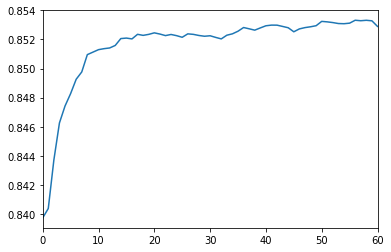

In [17]:
evaluation['auc-mean'].plot(kind='line')

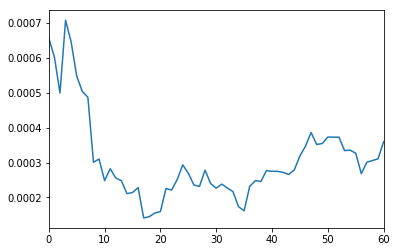

In [18]:
evaluation['auc-stdv'].plot(kind='line')

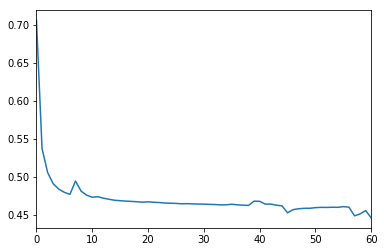

In [19]:
evaluation['binary_logloss-mean'].plot(kind='line')

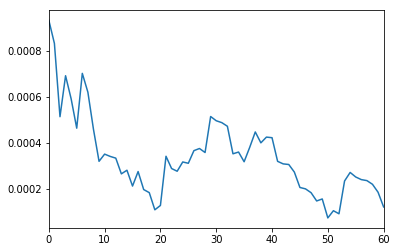

In [20]:
evaluation['binary_logloss-stdv'].plot(kind='line')

In [21]:
pickle.dump( params, open( "params.pkl", "wb" ) )

In [22]:
test = lgb.train(params, train_set = train_data, valid_sets = test_data, early_stopping_rounds=100, evals_result = eval_metrics)

/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's binary_logloss: 0.703103	valid_0's auc: 0.840275
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.536937	valid_0's auc: 0.839838
[3]	valid_0's binary_logloss: 0.504786	valid_0's auc: 0.844059
[4]	valid_0's binary_logloss: 0.489494	valid_0's auc: 0.847331
[5]	valid_0's binary_logloss: 0.482437	valid_0's auc: 0.848162
[6]	valid_0's binary_logloss: 0.477917	valid_0's auc: 0.849053
[7]	valid_0's binary_logloss: 0.475812	valid_0's auc: 0.85009
[8]	valid_0's binary_logloss: 0.494138	valid_0's auc: 0.850195
[9]	valid_0's binary_logloss: 0.479804	valid_0's auc: 0.851602
[10]	valid_0's binary_logloss: 0.474966	valid_0's auc: 0.851666
[11]	valid_0's binary_logloss: 0.47238	valid_0's auc: 0.851998
[12]	valid_0's binary_logloss: 0.472875	valid_0's auc: 0.85211
[13]	valid_0's binary_logloss: 0.471127	valid_0's auc: 0.852049
[14]	valid_0's binary_logloss: 0.469708	valid_0's auc: 0.852189
[15]	valid_0's binary_logloss: 0.468506	valid_0's auc

In [23]:
preds = test.predict(X_test)

In [24]:
y_max = []
for x in preds:
    if x > 0.5:
        y_max.append(1)
    else:
        y_max.append(0)
accuracy = accuracy_score(y_test, y_max)
cm = confusion_matrix(y_test, y_max)
report = classification_report(y_test,y_max)
auc = roc_auc_score(y_test, y_max)
print('Model {0} accuracy: {1}'.format(i, accuracy))
print('Model {0} auc: {1}'.format(i,auc))
print(cm)
print(report)

Model 4 accuracy: 0.7426268690283175
Model 4 auc: 0.7560598071673572
[[ 57349  16913]
 [207390 589857]]
              precision    recall  f1-score   support

           0       0.22      0.77      0.34     74262
           1       0.97      0.74      0.84    797247

    accuracy                           0.74    871509
   macro avg       0.59      0.76      0.59    871509
weighted avg       0.91      0.74      0.80    871509



In [25]:
test.save_model("final.txt")

In [ ]:
bst = lgb.Booster(model_file='final.txt')

In [26]:
!gsutil cp final.txt gs://kaggle-days-sf

Copying file://final.txt [Content-Type=text/plain]...
- [1 files][253.6 KiB/253.6 KiB]                                                
Operation completed over 1 objects/253.6 KiB.                                    
